In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from features import *
import pickle
import glob
from collections import deque

In [2]:
with open('params/svc_pickle.p', 'rb') as f:
    params = pickle.loads(f.read())

In [3]:
cell_per_block = params['cell_per_block']
hist_bins = params['hist_bins']
orient = params['orient']
pix_per_cell = params['pix_per_cell']
X_scaler = params['scaler']
spatial_size = params['spatial_size']
svc = params['svc']

In [44]:
from scipy.ndimage.measurements import label

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        h, w = abs(bbox[0][0]-bbox[1][0]), abs(bbox[0][1]-bbox[1][1])
        if h<50 or w<50:
            continue
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

def process_frame(img):
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    ystart, ystop = int(img.shape[0]*.5), int(img.shape[0]*.95)
    img_cropped = img[ystart:ystop, :, :]
    img_cropped = convert_color(img_cropped, conv='RGB2YCrCb')
    img_cropped = img_cropped.astype(np.float32)/255
    for scale in [1, 2]:
        gen = find_cars(img_cropped, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        for bbox in gen:
            bbox[0] = (bbox[0][0], ystart + bbox[0][1])
            bbox[1] = (bbox[1][0], ystart + bbox[1][1])
#             cv2.rectangle(draw_img, bbox[0], bbox[1], (0, 255, 0), 3)
            heatmap[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] += 1
    process_frame.buffer.append(heatmap)
        
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    for i in range(len(process_frame.buffer)):
        heatmap += process_frame.buffer[i]
    heatmap[heatmap < process_frame.threshold] = 0
    labels = label(heatmap)
    img = draw_labeled_bboxes(draw_img, labels)
    return img    
    heatmap = np.dstack((heatmap*5, np.zeros_like(heatmap), np.zeros_like(heatmap))).astype(np.uint8)
    heatmap = np.concatenate((img, heatmap), axis=1)
    return heatmap

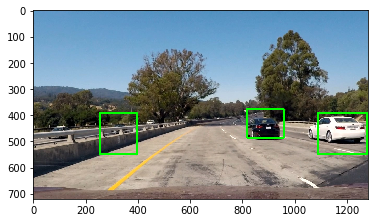

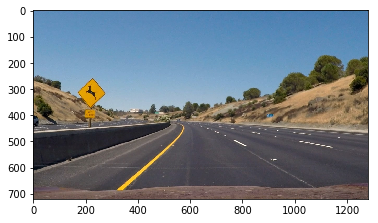

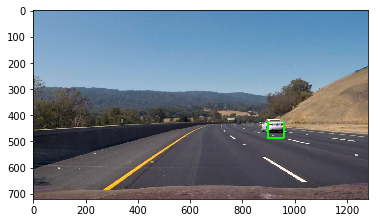

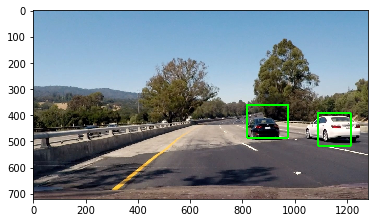

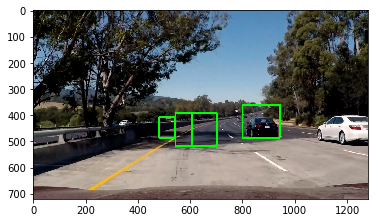

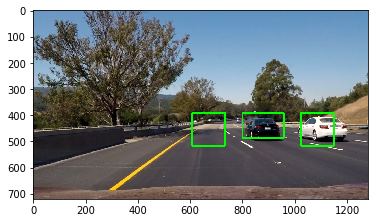

In [45]:
process_frame.threshold = 3
for img_name in glob.glob('test_images/*.jpg'):
    img = mpimg.imread(img_name)
    process_frame.buffer = deque(maxlen=1)
    img = process_frame(img)
    plt.imshow(img)
    plt.show()
#     plt.imsave('output_images/' + img_name.split('/')[1], img)

In [46]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [47]:
process_frame.threshold = 20
process_frame.buffer = deque(maxlen=10)
white_output = 'test_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:17<00:00,  1.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 17.3 s, sys: 496 ms, total: 17.8 s
Wall time: 19.4 s


In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [16]:
process_frame.threshold = 20
process_frame.buffer = deque(maxlen=10)
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [09:44<00:00,  2.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 9min 22s, sys: 13.7 s, total: 9min 36s
Wall time: 9min 45s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))